https://www.capitalbikeshare.com/

https://www.kaggle.com/marklvl/bike-sharing-dataset

In [1]:
# Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 999
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [2]:
df = pd.read_csv('hour.csv',index_col=0)
df.head()
# Import File csv
# Mengecheck Dataframe dari listing.csv

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df['yr'] = df['yr'].map({0:2011, 1:2012})
df['temp']=(df['temp']*(39+8)-8).round(2)
df['atemp']=(df['atemp']*(50+16)-16).round(2)
df['hum']=(df['hum']*100).round(2)
df['windspeed']=(df['windspeed']*67).round(2)
Q1 = df['cnt'].describe()['25%']
Q3 = df['cnt'].describe()['75%']
IQR = Q3 - Q1
upper_fence = Q3 + (1.5*IQR)
lower_fence = Q1 - (1.5*IQR)
df['event'] = df['cnt'].apply(lambda x: 0 if (x > lower_fence)&(x < upper_fence) else 1)
df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,1,2011,1,0,0,6,0,1,3.28,3.0,81.0,0.0,3,13,16,0
2,2011-01-01,1,2011,1,1,0,6,0,1,2.34,2.0,80.0,0.0,8,32,40,0
3,2011-01-01,1,2011,1,2,0,6,0,1,2.34,2.0,80.0,0.0,5,27,32,0
4,2011-01-01,1,2011,1,3,0,6,0,1,3.28,3.0,75.0,0.0,3,10,13,0
5,2011-01-01,1,2011,1,4,0,6,0,1,3.28,3.0,75.0,0.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0


## Data Preparation

In [4]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'event'],
      dtype='object')

In [5]:
df_ML = df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt','event']]
df_ML.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,event
instant,,,,,,,,,,,,,
1,1,2011,1,0,0,6,0,1,3.0,81.0,0.0,16,0
2,1,2011,1,1,0,6,0,1,2.0,80.0,0.0,40,0
3,1,2011,1,2,0,6,0,1,2.0,80.0,0.0,32,0
4,1,2011,1,3,0,6,0,1,3.0,75.0,0.0,13,0
5,1,2011,1,4,0,6,0,1,3.0,75.0,0.0,1,0


In [6]:
X = df_ML.drop(columns='cnt')
y = df_ML['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

## Base Model

In [7]:
num_columns = ['yr', 'atemp', 'hum', 'windspeed']
cat_columns = ['season', 'mnth', 'hr','holiday', 'weekday','workingday', 'weathersit','event']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

categoric_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_DT_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeRegressor(random_state=36)),
])

pipe_RF_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(random_state=36)),
])

pipe_XGB_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(random_state=36)),
])

## Evaluation Matrix Base Model

In [8]:
def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    R2 = r2_score(y_true, y_pred)*100
    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    return R2, MAE, MSE, RMSE

### DecisionTree

In [9]:
pipe_DT_Base.fit(X_train,y_train)
R2_train_DT,MAE_train_DT,MSE_train_DT,RMSE_train_DT = Eva_Matrix(pipe_DT_Base, X_train,y_train)
R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT = Eva_Matrix(pipe_DT_Base, X_test,y_test)
dataDT = {
    'Training':[R2_train_DT,MAE_train_DT,MSE_train_DT,RMSE_train_DT],
    'Testing':[R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT]
}
pd.DataFrame(data=dataDT, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,99.999884,90.023868
MAE,0.002915,34.598964
MSE,0.037901,3308.480380
RMSE,0.194681,57.519391


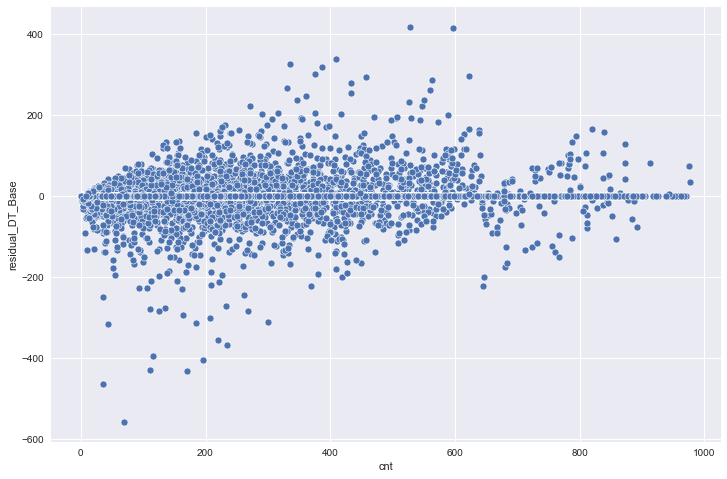

In [10]:
y_predict_DT_Base=pipe_DT_Base.predict(X)
df_ML['residual_DT_Base'] = y - y_predict_DT_Base
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_DT_Base', data=df_ML)
plt.show()

In [11]:
resiplus=df_ML[df_ML['residual_DT_Base']>0]
resimin=df_ML[df_ML['residual_DT_Base']<=0]
resiplus['residual_DT_Base'].count()/df_ML['residual_DT_Base'].count(), resimin['residual_DT_Base'].count()/df_ML['residual_DT_Base'].count()

(0.12146843892053628, 0.8785315610794637)

### RandomForest

In [12]:
pipe_RF_Base.fit(X_train,y_train)
R2_train_RF,MAE_train_RF,MSE_train_RF,RMSE_train_RF = Eva_Matrix(pipe_RF_Base, X_train,y_train)
R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF = Eva_Matrix(pipe_RF_Base, X_test,y_test)
dataRF = {
    'Training':[R2_train_RF,MAE_train_RF,MSE_train_RF,RMSE_train_RF],
    'Testing':[R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF]
}
pd.DataFrame(data=dataRF, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,99.292512,94.908314
MAE,9.351591,25.702521
MSE,232.128281,1688.604542
RMSE,15.235757,41.092634


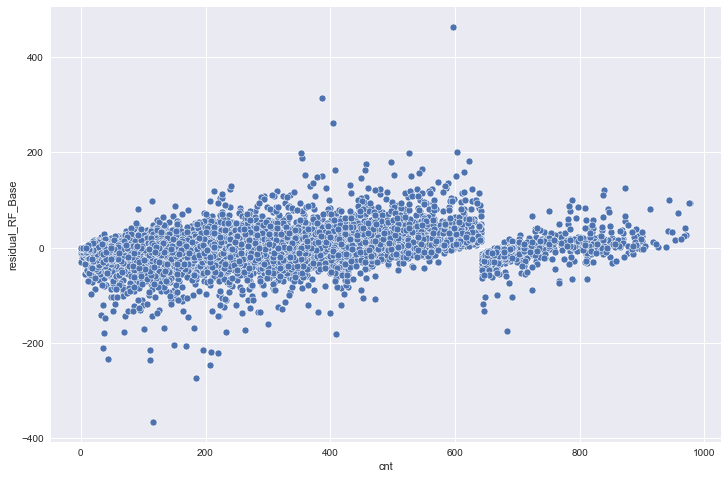

In [13]:
y_predict_RF_Base=pipe_RF_Base.predict(X)
df_ML['residual_RF_Base'] = y - y_predict_RF_Base
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_Base', data=df_ML)
plt.show()

In [14]:
resiplus=df_ML[df_ML['residual_RF_Base']>0]
resimin=df_ML[df_ML['residual_RF_Base']<=0]
resiplus['residual_RF_Base'].count()/df_ML['residual_RF_Base'].count(), resimin['residual_RF_Base'].count()/df_ML['residual_RF_Base'].count()

(0.4695321940272743, 0.5304678059727257)

### XGB

In [15]:
pipe_XGB_Base.fit(X_train,y_train)
R2_train_XGB,MAE_train_XGB,MSE_train_XGB,RMSE_train_XGB = Eva_Matrix(pipe_XGB_Base, X_train,y_train)
R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB = Eva_Matrix(pipe_XGB_Base, X_test,y_test)
dataXGB = {
    'Training':[R2_train_XGB,MAE_train_XGB,MSE_train_XGB,RMSE_train_XGB],
    'Testing':[R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB]
}
pd.DataFrame(data=dataXGB, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,97.563629,94.987489
MAE,18.579046,26.070419
MSE,799.378196,1662.347040
RMSE,28.273277,40.771890


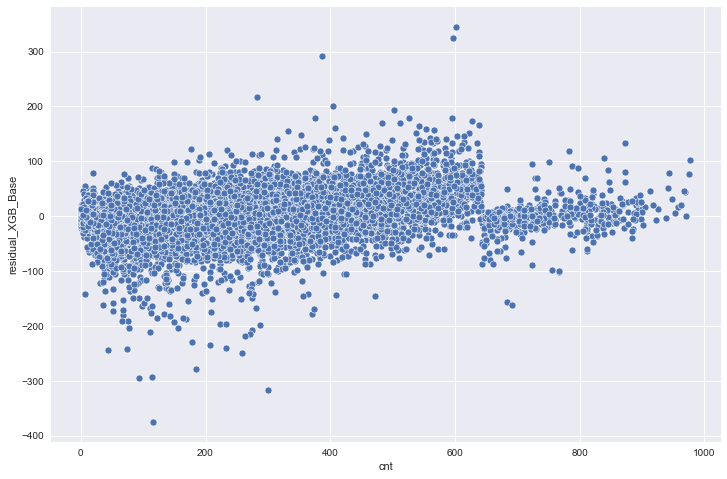

In [16]:
y_predict_XGB_Base=pipe_XGB_Base.predict(X)
df_ML['residual_XGB_Base'] = y - y_predict_XGB_Base
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_Base', data=df_ML)
plt.show()

In [17]:
resiplus=df_ML[df_ML['residual_XGB_Base']>0]
resimin=df_ML[df_ML['residual_XGB_Base']<=0]
resiplus['residual_XGB_Base'].count()/df_ML['residual_XGB_Base'].count(), resimin['residual_XGB_Base'].count()/df_ML['residual_XGB_Base'].count()

(0.49582829852120375, 0.5041717014787962)

## Hyper Parameter Tuning

### RF Bayes

In [59]:
param_RF = {
     'algo__n_estimators' : np.arange(100,8000,10),
     'algo__max_features': [None, 'auto', 'sqrt'],
     'algo__max_depth':    np.arange(1, 101, 5),
     'algo__min_samples_split' : np.arange(2, 8, 2),
     'algo__min_samples_leaf': np.arange(1, 10, 1),
}
RF_BS = BayesSearchCV(pipe_RF_Base, param_RF, cv = 3, n_jobs = -1, verbose=1)
RF_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   43.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   57.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.7s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [60]:
RF_BS.best_params_

OrderedDict([('algo__max_depth', 36),
             ('algo__max_features', 'auto'),
             ('algo__min_samples_leaf', 1),
             ('algo__min_samples_split', 4),
             ('algo__n_estimators', 4010)])

In [61]:
RF_BS = RF_BS.best_estimator_
R2_train_RF_BS,MAE_train_RF_BS,MSE_train_RF_BS,RMSE_train_RF_BS = Eva_Matrix(RF_BS, X_train,y_train)
R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS = Eva_Matrix(RF_BS, X_test,y_test)
dataRF_BS = {
    'Training':[R2_train_RF_BS,MAE_train_RF_BS,MSE_train_RF_BS,RMSE_train_RF_BS],
    'Testing':[R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS]
}
pd.DataFrame(data=dataRF_BS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,99.015141,95.012911
MAE,11.005402,25.469239
MSE,323.134261,1653.916087
RMSE,17.975936,40.668367


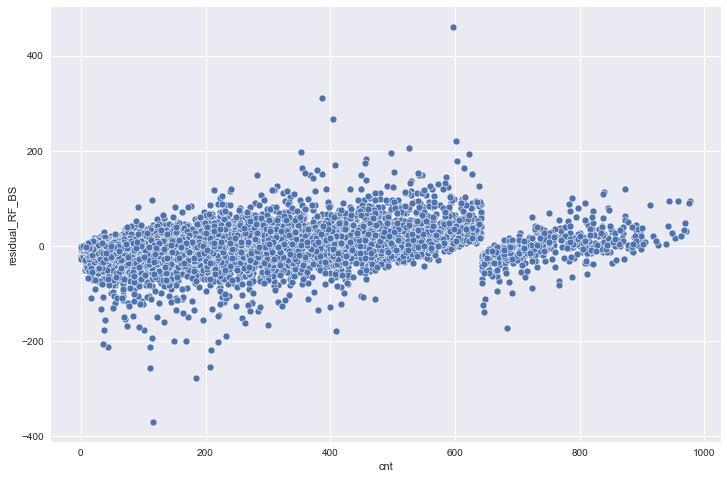

In [62]:
y_predict_RF_BS=RF_BS.predict(X)
df_ML['residual_RF_BS'] = y - y_predict_RF_BS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_BS', data=df_ML)
plt.show()

In [63]:
resiplus=df_ML[df_ML['residual_RF_BS']>0]
resimin=df_ML[df_ML['residual_RF_BS']<=0]
resiplus['residual_RF_BS'].count()/df_ML['residual_RF_BS'].count(), resimin['residual_RF_BS'].count()/df_ML['residual_RF_BS'].count()

(0.47033776396800736, 0.5296622360319926)

### RF Random

In [23]:
param_RF1 = {
     'algo__n_estimators' : np.arange(100,8000,10),
     'algo__max_features': [None, 'auto', 'sqrt'],
     'algo__max_depth':    np.arange(1, 50, 5),
     'algo__min_samples_split' : np.arange(2, 8, 2),
     'algo__min_samples_leaf': np.arange(1, 10, 1),
}
RF_RS = RandomizedSearchCV(pipe_RF_Base, param_RF1, cv = 3, n_jobs = -1, verbose=1)
RF_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.2min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['yr',
                                                                                'atemp',
                                                                                'hum',
                                                                                'windspeed']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                  

In [24]:
RF_RS.best_params_

{'algo__n_estimators': 4410,
 'algo__min_samples_split': 2,
 'algo__min_samples_leaf': 4,
 'algo__max_features': 'auto',
 'algo__max_depth': 36}

In [25]:
RF_RS = RF_RS.best_estimator_
R2_train_RF_RS,MAE_train_RF_RS,MSE_train_RF_RS,RMSE_train_RF_RS = Eva_Matrix(RF_RS, X_train,y_train)
R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS = Eva_Matrix(RF_RS, X_test,y_test)
dataRF_RS = {
    'Training':[R2_train_RF_RS,MAE_train_RF_RS,MSE_train_RF_RS,RMSE_train_RF_RS],
    'Testing':[R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS]
}
pd.DataFrame(data=dataRF_RS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,97.391447,94.754490
MAE,17.957499,26.154668
MSE,855.871215,1739.618630
RMSE,29.255277,41.708736


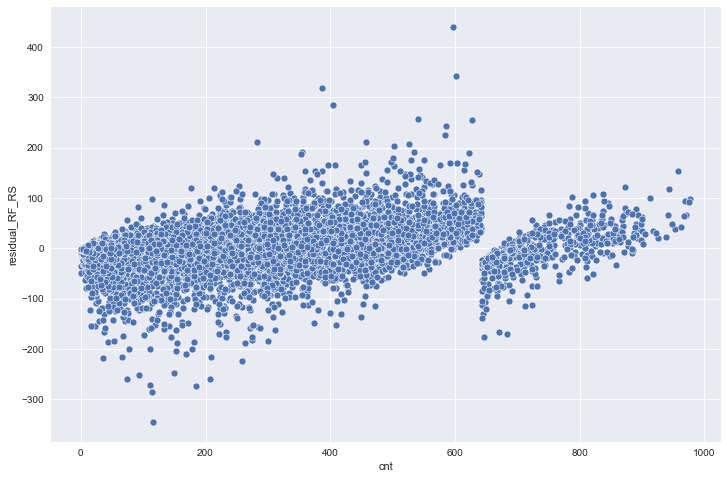

In [26]:
y_predict_RF_RS = RF_RS.predict(X)
df_ML['residual_RF_RS'] = y - y_predict_RF_RS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_RS', data=df_ML)
plt.show()

In [27]:
resiplus=df_ML[df_ML['residual_RF_RS']>0]
resimin=df_ML[df_ML['residual_RF_RS']<=0]
resiplus['residual_RF_RS'].count()/df_ML['residual_RF_RS'].count(), resimin['residual_RF_RS'].count()/df_ML['residual_RF_RS'].count()

(0.4798319811266471, 0.5201680188733528)

### DT Bayes

In [28]:
param_DT = {
     'algo__max_features': [None, 'auto'],
     'algo__max_depth':    np.arange(1, 101, 2),
     'algo__min_samples_split' : np.arange(1,21,1)*2,
     'algo__min_samples_leaf': np.arange(1,21,1),
}
DT_BS = BayesSearchCV(pipe_DT_Base, param_DT, cv = 3, n_jobs = -1, verbose=1)
DT_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [29]:
DT_BS.best_params_

OrderedDict([('algo__max_depth', 21),
             ('algo__max_features', None),
             ('algo__min_samples_leaf', 2),
             ('algo__min_samples_split', 14)])

In [30]:
DT_BS = DT_BS.best_estimator_
R2_train_DT_BS,MAE_train_DT_BS,MSE_train_DT_BS,RMSE_train_DT_BS = Eva_Matrix(DT_BS, X_train,y_train)
R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS = Eva_Matrix(DT_BS, X_test,y_test)
dataDT_BS = {
    'Training':[R2_train_DT_BS,MAE_train_DT_BS,MSE_train_DT_BS,RMSE_train_DT_BS],
    'Testing':[R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS]
}
pd.DataFrame(data=dataDT_BS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,96.968371,92.209583
MAE,19.265345,31.291248
MSE,994.683419,2583.610830
RMSE,31.538602,50.829232


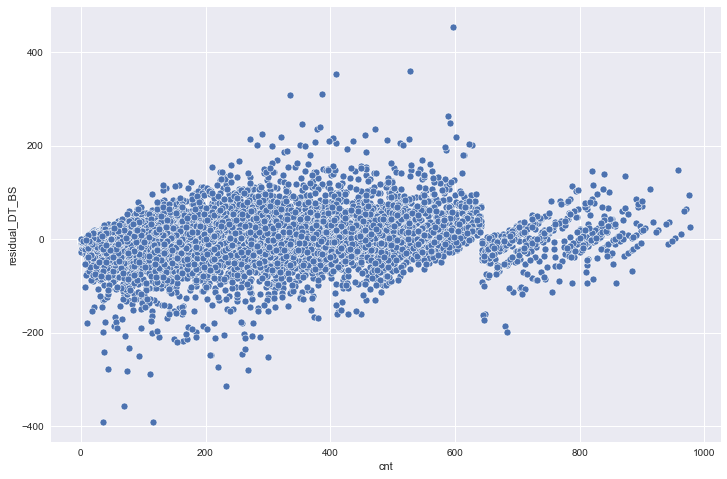

In [31]:
y_predict_DT_BS=DT_BS.predict(X)
df_ML['residual_DT_BS'] = y - y_predict_DT_BS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_BS', data=df_ML)
plt.show()

In [32]:
resiplus=df_ML[df_ML['residual_DT_BS']>0]
resimin=df_ML[df_ML['residual_DT_BS']<=0]
resiplus['residual_DT_BS'].count()/df_ML['residual_DT_BS'].count(), resimin['residual_DT_BS'].count()/df_ML['residual_DT_BS'].count()

(0.4897865239657057, 0.5102134760342942)

### DT Grid

In [33]:
param_DT1 = {
     'algo__max_features': [None, 'auto'],
     'algo__max_depth':    np.arange(1, 101, 2),
     'algo__min_samples_split' : np.arange(1,21,1)*2,
     'algo__min_samples_leaf': np.arange(1,21,1),
}
DT_GS = GridSearchCV(pipe_DT_Base, param_DT1, cv = 3, n_jobs = -1, verbose=1)
DT_GS.fit(X_train, y_train)

Fitting 3 folds for each of 40000 candidates, totalling 120000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12028 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 14328 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 16828 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 19528 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 22428 tasks 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['yr',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='mo

In [34]:
DT_GS.best_params_

{'algo__max_depth': 15,
 'algo__max_features': None,
 'algo__min_samples_leaf': 2,
 'algo__min_samples_split': 12}

In [35]:
DT_GS = DT_GS.best_estimator_
R2_train_DT_GS,MAE_train_DT_GS,MSE_train_DT_GS,RMSE_train_DT_GS = Eva_Matrix(DT_GS, X_train,y_train)
R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS = Eva_Matrix(DT_GS, X_test,y_test)
dataDT_GS = {
    'Training':[R2_train_DT_GS,MAE_train_DT_GS,MSE_train_DT_GS,RMSE_train_DT_GS],
    'Testing':[R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS]
}
pd.DataFrame(data=dataDT_GS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,96.821260,92.081840
MAE,19.923386,31.551836
MSE,1042.950694,2625.975484
RMSE,32.294747,51.244273


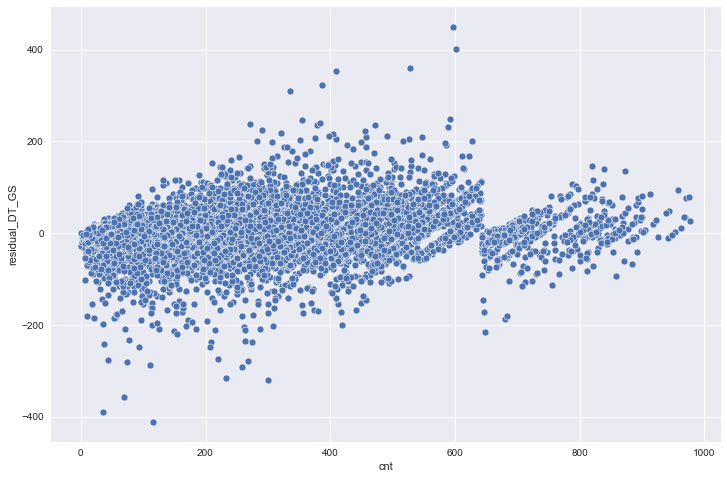

In [36]:
y_predict_DT_GS=DT_GS.predict(X)
df_ML['residual_DT_GS'] = y - y_predict_DT_GS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_GS', data=df_ML)
plt.show()

### DT Grid2

In [37]:
param_DT2 = {
    'algo__criterion' : ['mae'],
    'algo__max_features': [None],
    'algo__max_depth': [17],
    'algo__min_samples_split' : [16],
    'algo__min_samples_leaf': [2],
}
DT_GS2 = GridSearchCV(pipe_DT_Base, param_DT2, cv = 3, n_jobs = -1, verbose=1)
DT_GS2.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['yr',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='mo

In [38]:
DT_GS2.best_params_

{'algo__criterion': 'mae',
 'algo__max_depth': 17,
 'algo__max_features': None,
 'algo__min_samples_leaf': 2,
 'algo__min_samples_split': 16}

In [39]:
DT_GS2 = DT_GS2.best_estimator_
R2_train_DT_GS2,MAE_train_DT_GS2,MSE_train_DT_GS2,RMSE_train_DT_GS2 = Eva_Matrix(DT_GS2, X_train,y_train)
R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2 = Eva_Matrix(DT_GS2, X_test,y_test)
dataDT_GS2 = {
    'Training':[R2_train_DT_GS2,MAE_train_DT_GS2,MSE_train_DT_GS2,RMSE_train_DT_GS2],
    'Testing':[R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2]
}
pd.DataFrame(data=dataDT_GS2, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,95.728153,91.192706
MAE,19.960488,32.342923
MSE,1401.601235,2920.847411
RMSE,37.437965,54.044865


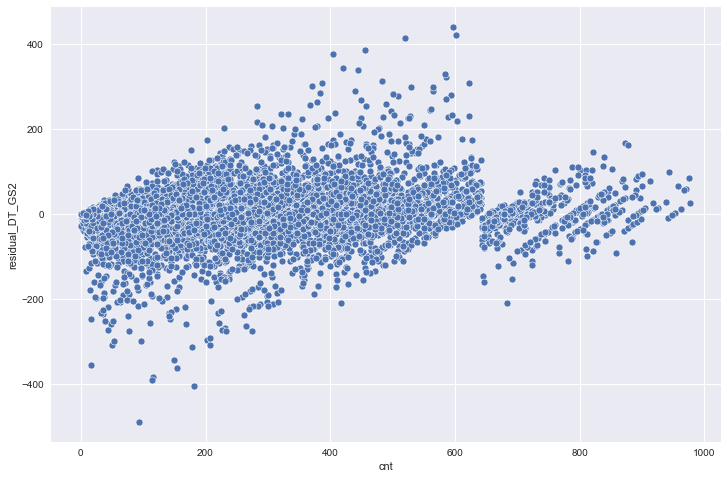

In [40]:
y_predict_DT_GS2=DT_GS2.predict(X)
df_ML['residual_DT_GS2'] = y - y_predict_DT_GS2
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_GS2', data=df_ML)
plt.show()

In [41]:
resiplus=df_ML[df_ML['residual_DT_GS2']>0]
resimin=df_ML[df_ML['residual_DT_GS2']<=0]
resiplus['residual_DT_GS2'].count()/df_ML['residual_DT_GS2'].count(), resimin['residual_DT_GS2'].count()/df_ML['residual_DT_GS2'].count()

(0.4565279935554405, 0.5434720064445595)

### XGB Random

In [42]:
param_XGB = {
    'algo__n_estimators' : np.arange(100, 8000, 100),
    'algo__learning_rate' : [None, 0.1, 0.3, 0.5, 0.8, 1],
    'algo__max_depth' : np.arange(1, 50, 5),
#     'algo__min_child_weight': [None, 5, 10, 25, 30, 40, 50, 60, 80, 95, 100],
#     'algo__objective' : ['reg:squarederror'],
#     'algo__eval_metric' : ['mae']

    

}
XGB_RS = RandomizedSearchCV(pipe_XGB_Base, param_XGB, cv = 3, n_jobs = -1, verbose=1)
XGB_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['yr',
                                                                                'atemp',
                                                                                'hum',
                                                                                'windspeed']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                  

In [43]:
XGB_RS.best_params_

{'algo__n_estimators': 2600, 'algo__max_depth': 21, 'algo__learning_rate': 0.1}

In [44]:
XGB_RS = XGB_RS.best_estimator_
R2_train_XGB_RS,MAE_train_XGB_RS,MSE_train_XGB_RS,RMSE_train_XGB_RS = Eva_Matrix(XGB_RS, X_train,y_train)
R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS = Eva_Matrix(XGB_RS, X_test,y_test)
dataXGB_RS = {
    'Training':[R2_train_XGB_RS,MAE_train_XGB_RS,MSE_train_XGB_RS,RMSE_train_XGB_RS],
    'Testing':[R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS]
}
pd.DataFrame(data=dataXGB_RS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,99.999884,95.129104
MAE,0.003515,24.999045
MSE,0.037902,1615.381840
RMSE,0.194684,40.191813


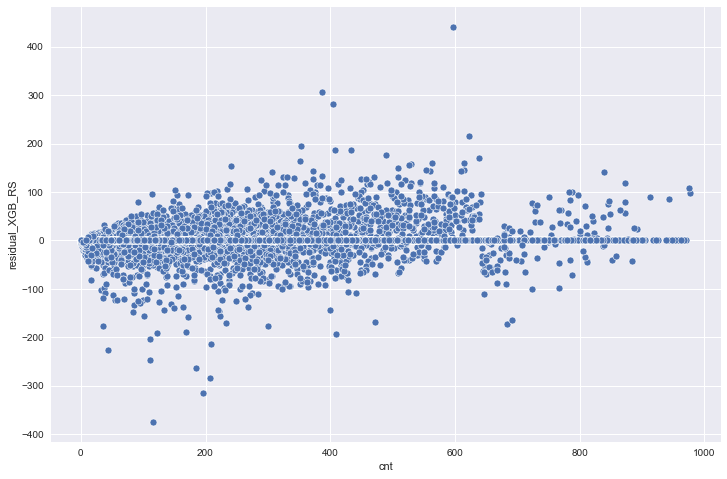

In [45]:
y_predict_XGB_RS=XGB_RS.predict(X)
df_ML['residual_XGB_RS'] = y - y_predict_XGB_RS
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_RS', data=df_ML)
plt.show()

In [46]:
resiplus=df_ML[df_ML['residual_XGB_RS']>0]
resimin=df_ML[df_ML['residual_XGB_RS']<=0]
resiplus['residual_XGB_RS'].count()/df_ML['residual_XGB_RS'].count(), resimin['residual_XGB_RS'].count()/df_ML['residual_XGB_RS'].count()

(0.47442315438172505, 0.5255768456182749)

### XGB Bayes

In [47]:
param_XGB1 = {
    'algo__n_estimators' : np.arange(100, 8000, 100),
    'algo__learning_rate' : [None, 0.1, 0.3, 0.5, 0.8, 1],
    'algo__max_depth' : np.arange(1, 50, 5),
#     'algo__min_child_weight': [None, 5, 10, 25, 30, 40, 50, 60, 80, 95, 100],
#     'algo__objective' : ['reg:squarederror'],
#     'algo__eval_metric' : ['mae']

    

}
XGB_BS = BayesSearchCV(pipe_XGB_Base, param_XGB1, cv = 3, n_jobs = -1, verbose=1)
XGB_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   56.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.5s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [48]:
XGB_BS.best_params_

OrderedDict([('algo__learning_rate', 0.1),
             ('algo__max_depth', 6),
             ('algo__n_estimators', 1300)])

In [49]:
XGB_BS = XGB_BS.best_estimator_
R2_train_XGB_BS,MAE_train_XGB_BS,MSE_train_XGB_BS,RMSE_train_XGB_BS = Eva_Matrix(XGB_BS, X_train,y_train)
R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS = Eva_Matrix(XGB_BS, X_test,y_test)
dataXGB_BS = {
    'Training':[R2_train_XGB_BS,MAE_train_XGB_BS,MSE_train_XGB_BS,RMSE_train_XGB_BS],
    'Testing':[R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS]
}
pd.DataFrame(data=dataXGB_BS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,99.228797,95.581574
MAE,10.269839,24.173548
MSE,253.033319,1465.324953
RMSE,15.907021,38.279563


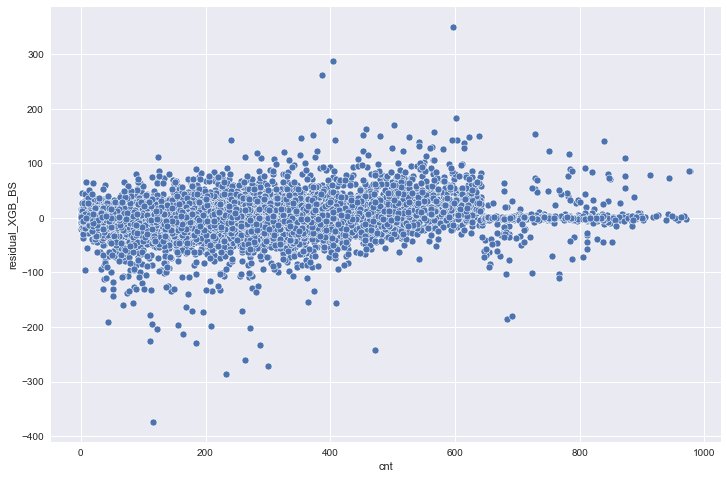

In [50]:
y_predict_XGB_BS=XGB_BS.predict(X)
df_ML['residual_XGB_BS'] = y - y_predict_XGB_BS
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_BS', data=df_ML)
plt.show()

In [51]:
resiplus=df_ML[df_ML['residual_XGB_BS']>0]
resimin=df_ML[df_ML['residual_XGB_BS']<=0]
resiplus['residual_XGB_BS'].count()/df_ML['residual_XGB_BS'].count(), resimin['residual_XGB_BS'].count()/df_ML['residual_XGB_BS'].count()

(0.4980148455031935, 0.5019851544968065)

## Compare

In [102]:
datacom = {
    'Base DT' : [R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT,df_ML[df_ML['residual_DT_Base']<=0]['residual_DT_Base'].count()/df_ML['residual_DT_Base'].count()],
    'Base RF' : [R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF,df_ML[df_ML['residual_RF_Base']<=0]['residual_RF_Base'].count()/df_ML['residual_RF_Base'].count()],
    'Base XGB' : [R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB,df_ML[df_ML['residual_XGB_Base']<=0]['residual_XGB_Base'].count()/df_ML['residual_XGB_Base'].count()],
    'RF Tuned Bayes' : [R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS,df_ML[df_ML['residual_RF_BS']<=0]['residual_RF_BS'].count()/df_ML['residual_RF_BS'].count()],
    'RF Tuned Random' : [R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS,df_ML[df_ML['residual_RF_RS']<=0]['residual_RF_RS'].count()/df_ML['residual_RF_RS'].count()],
    'DT Tuned Bayes' : [R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS,df_ML[df_ML['residual_DT_BS']<=0]['residual_DT_BS'].count()/df_ML['residual_DT_BS'].count()],
    'DT Tuned Grid 1' : [R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS,df_ML[df_ML['residual_DT_GS']<=0]['residual_DT_GS'].count()/df_ML['residual_DT_GS'].count()],
    'DT Tuned Grid 2' : [R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2,df_ML[df_ML['residual_DT_GS2']<=0]['residual_DT_GS2'].count()/df_ML['residual_DT_GS2'].count()],
    'XGB Tuned Random' : [R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS,df_ML[df_ML['residual_XGB_RS']<=0]['residual_XGB_RS'].count()/df_ML['residual_XGB_RS'].count()],
    'XGB Tuned Bayes' : [R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS,df_ML[df_ML['residual_XGB_BS']<=0]['residual_XGB_BS'].count()/df_ML['residual_XGB_BS'].count()]
}
compare = pd.DataFrame(data=datacom, index=["R Squared", "MAE", "MSE", "RMSE", 'Residual_Minus']).T
print('Komparasi Evaluation Matrix')
compare.reset_index(inplace=True)
compare.sort_values('Residual_Minus', ascending=False)


Komparasi Evaluation Matrix


,index,R Squared,MAE,MSE,RMSE,Residual_Minus
0,Base DT,90.023868,34.598964,3308.480380,57.519391,0.878532
7,DT Tuned Grid 2,91.192706,32.342923,2920.847411,54.044865,0.543472
1,Base RF,94.908314,25.702521,1688.604542,41.092634,0.530468
3,RF Tuned Bayes,95.012911,25.469239,1653.916087,40.668367,0.529662
8,XGB Tuned Random,95.129104,24.999045,1615.381840,40.191813,0.525577
4,RF Tuned Random,94.754490,26.154668,1739.618630,41.708736,0.520168
6,DT Tuned Grid 1,92.081840,31.551836,2625.975484,51.244273,0.511997
5,DT Tuned Bayes,92.209583,31.291248,2583.610830,50.829232,0.510213
2,Base XGB,94.987489,26.070419,1662.347040,40.771890,0.504172
9,XGB Tuned Bayes,95.581574,24.173548,1465.324953,38.279563,0.501985


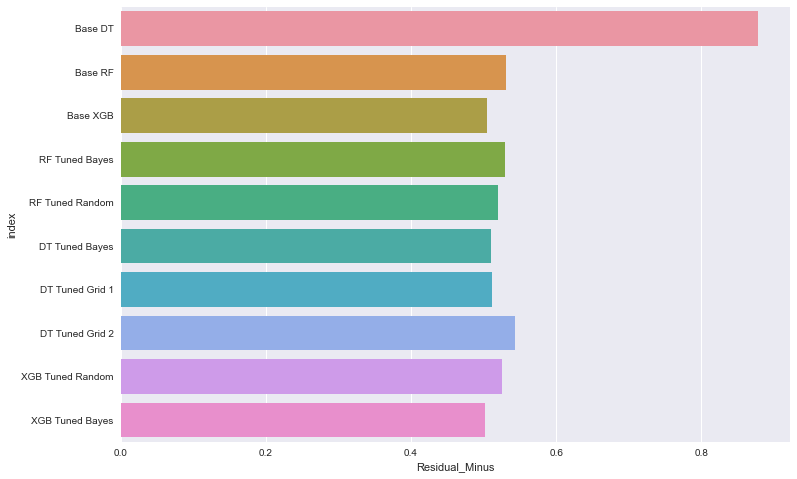

In [82]:
plt.figure(figsize=(12,8))
sns.barplot('Residual_Minus','index', data=compare)
plt.show()

## Insight Machine Learning
Berdasarkan Evaluation Matrix di atas, Ditemukan 5 Model Machine Learning yang memenuhi kriteria Bike Sharing Prediction. Dengan basis scoring R-Squared, MAE, dan Residual Negative.
- `Base DT` Mempunyai nilai Residual Negative terbaik, tetapi model tersebut Overfitting. 
- `Decision Tree Grid 2`, adalah model yang memiliki Residual Negative tertinggi setelah `Base DT`, tetapi nilai MAE nya di atas rata-rata MAE semua model. 
- `Base RF`, `RF Tuned Bayes`, dan `XGB Tuned Randomized` memiliki nilai Evaluation Matrix yang mirip.

## Conclusion Machine Learning
Best Model Machine Learning yang dipilih adalah **RF Tuned Bayes**, karena memiliki nilai R-Squared yang tinggi sebesar 95 dan MAE lebih rendah di bandingkan dengan rata-rata MAE semua model (lebih baik dibandingkan `Base RF`) dan Memiliki Nilai Residual Negative 52,96% (lebih tinggi dibandingkan `XGB Tuned Randomized`).


## Simulasi Model
- Diambil dari web _capital-bikeshare_, harga sewa sepeda adalah $\$$ 2 per 30 menit (atau $\$$ 4 per jam).
- Diasumsikan dari $\$$ 4 itu, $\$$ 2 dialokasikan untuk cost maintenance per sepeda.
- Jika dianggap prediksi lebih sedikit mengakibatkan lost customer ($\$$ 4) dan prediksi lebih banyak mengakibatkan sepeda maintenance cost ($\$$ 2)
- Diasumsikan juga bahwa sebelumnya, jumlah penyewaan sepeda diprediksi menggunakan Metode Konvensional, yaitu dengan mengambil nilai rata-rata (atau Q3) dari bulan sebelumnya.
- Berdasarkan asumsi-asumsi tersebut, dilakukan Simulasi untuk melihat perbandingan Cost dari Model Machine Larning dibandingan dengan Cost dari Metode Konvensional (Mean dan Q3).

In [164]:
## Memisahkan data untuk Simulasi
## Data Test untuk Simulasi menggunakan Data dari Dataset Bike Sharing khusus Bulan Desember 2012
test=df[(df['mnth']==12)&(df['yr']=='2012')]
train=df[~((df['mnth']==12)&(df['yr']=='2012'))]
test.shape, train.shape

((742, 17), (16637, 17))

### Data Preparation

In [104]:
df_ML2 = train[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt','event']]
df_ML2.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,event
instant,,,,,,,,,,,,,
1,1,2011,1,0,0,6,0,1,3.0,81.0,0.0,16,0
2,1,2011,1,1,0,6,0,1,2.0,80.0,0.0,40,0
3,1,2011,1,2,0,6,0,1,2.0,80.0,0.0,32,0
4,1,2011,1,3,0,6,0,1,3.0,75.0,0.0,13,0
5,1,2011,1,4,0,6,0,1,3.0,75.0,0.0,1,0


In [110]:
X2 = df_ML2.drop(columns='cnt')
y2 = df_ML2['cnt']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=36)

### RandomForest Manual Tuning

In [119]:
RF=RandomForestRegressor(random_state=36, n_estimators=4010, max_features='auto', max_depth=36,min_samples_split=4,min_samples_leaf=1)
RF.fit(X2_train, y2_train)

RandomForestRegressor(max_depth=36, min_samples_split=4, n_estimators=4010,
                      random_state=36)

In [121]:
R2_train_RF2_BS,MAE_train_RF2_BS,MSE_train_RF2_BS,RMSE_train_RF2_BS = Eva_Matrix(RF, X2_train,y2_train)
R2_test_RF2_BS,MAE_test_RF2_BS,MSE_test_RF2_BS,RMSE_test_RF2_BS = Eva_Matrix(RF, X2_test,y2_test)
dataRF2_BS = {
    'Training':[R2_train_RF2_BS,MAE_train_RF2_BS,MSE_train_RF2_BS,RMSE_train_RF2_BS],
    'Testing':[R2_test_RF2_BS,MAE_test_RF2_BS,MSE_test_RF2_BS,RMSE_test_RF2_BS]
}
pd.DataFrame(data=dataRF2_BS, index=["R Squared", "MAE", "MSE", "RMSE"])

,Training,Testing
R Squared,98.967390,95.411882
MAE,11.157185,24.688887
MSE,342.784342,1511.252746
RMSE,18.514436,38.874834


### Model Predict

In [165]:
test['pred']=np.ceil(RF.predict(test.drop(columns=['cnt','dteday','casual','registered','temp'])))
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,pred
instant,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,116.0
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,97.0
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,59.0
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,16.0
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,286.0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,202.0
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,140.0


In [167]:
## Mengambil Data untuk Metode Konvensional
sampling=train[(train['mnth']==11)&(train['yr']=='2012')]
sampling

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event
instant,,,,,,,,,,,,,,,,,
15920,2012-11-01,4,2012,11,0,0,4,1,1,8.92,8.0,57.0,6.0,8,52,60,0
15921,2012-11-01,4,2012,11,1,0,4,1,1,6.10,5.0,75.0,7.0,8,22,30,0
15922,2012-11-01,4,2012,11,2,0,4,1,1,7.04,6.0,66.0,9.0,10,10,20,0
15923,2012-11-01,4,2012,11,3,0,4,1,1,7.98,6.0,61.0,9.0,5,10,15,0
15924,2012-11-01,4,2012,11,4,0,4,1,2,7.98,7.0,66.0,7.0,2,8,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16633,2012-11-30,4,2012,11,19,0,5,1,1,7.04,7.0,66.0,0.0,18,359,377,0
16634,2012-11-30,4,2012,11,20,0,5,1,1,7.04,7.0,66.0,0.0,12,233,245,0
16635,2012-11-30,4,2012,11,21,0,5,1,1,6.10,5.0,75.0,6.0,14,169,183,0


In [168]:
test['predQ3']=0
for k in range(742):
    ind=test.iloc[k]['weekday']
    waktu=test.iloc[k]['hr']
    hari=sampling[sampling['weekday']==ind]
    q3=hari[hari['hr']==waktu]['cnt'].describe()['75%']
    test['predQ3'].iloc[k]=q3

In [169]:
test['predMean']=0
for k in range(742):
    ind=test.iloc[k]['weekday']
    waktu=test.iloc[k]['hr']
    hari=sampling[sampling['weekday']==ind]
    mean=hari[hari['hr']==waktu]['cnt'].describe()['mean']
    test['predMean'].iloc[k]=mean

In [170]:
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,pred,predQ3,predMean
instant,,,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,116.0,111.50,94.50
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,97.0,87.50,68.00
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,59.0,46.75,42.75
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,16.0,22.75,20.00
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,10.0,9.25,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,286.0,380.50,375.50
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,202.0,283.75,270.25
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,140.0,186.50,172.75


In [171]:
## Perhitungan Simulasi
test['gap_pred']=test['cnt']-test['pred']
test['gap_predQ3']=test['cnt']-test['predQ3']
test['gap_predMean']=test['cnt']-test['predMean']
test['sales']=test['cnt']*4
test['cost_pred']=test['gap_pred'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predQ3']=test['gap_predQ3'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predMean']=test['gap_predMean'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,pred,predQ3,predMean,gap_pred,gap_predQ3,gap_predMean,sales,cost_pred,cost_predQ3,cost_predMean
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,116.0,111.50,94.50,-8.0,-3.50,13.50,432,16.0,7.0,54.0
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,97.0,87.50,68.00,-28.0,-18.50,1.00,276,56.0,37.0,4.0
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,59.0,46.75,42.75,-9.0,3.25,7.25,200,18.0,13.0,29.0
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,16.0,22.75,20.00,-1.0,-7.75,-5.00,60,2.0,15.5,10.0
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,10.0,9.25,8.00,-5.0,-4.25,-3.00,20,10.0,8.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,286.0,380.50,375.50,-167.0,-261.50,-256.50,476,334.0,523.0,513.0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,202.0,283.75,270.25,-113.0,-194.75,-181.25,356,226.0,389.5,362.5
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,140.0,186.50,172.75,-50.0,-96.50,-82.75,360,100.0,193.0,165.5


In [187]:
print('Perbandingan Aktual Sales dan Cost tiap Metode/Model')
test[['sales','cost_pred','cost_predQ3','cost_predMean']].sum()

Perbandingan Sales dan Cost tiap Metode/Model


sales            494852.000000
cost_pred         92222.000000
cost_predQ3      130795.000000
cost_predMean    123343.733333
dtype: float64

In [188]:
print('Persentase Cost terhadap Aktual Sales')
test[['cost_pred','cost_predQ3','cost_predMean']].sum()/test['sales'].sum()*100

Persentase Cost terhadap Aktual Sales


cost_pred        18.636279
cost_predQ3      26.431135
cost_predMean    24.925378
dtype: float64

## Conclusion Simulasi dengan Model Machine Learning
Walaupun Model Machine Learning masih belum sempurna, tetapi Model Machine Learning memiliki presentase Cost yang lebih rendah (dibandingkan Metode Konvensional) sebesar 6% - 7% per Bulan. Bisa disimpulkan Model Machine Learning bisa digunakan karena sudah lebih baik dibandingkan Metode Konvensional.

## Export Model

In [194]:
import joblib

In [195]:
joblib.dump(RF_BS, 'Model_RF_BS')

['Model_RF_BS']